In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader,random_split
from torchvision import transforms, datasets, models
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
model = models.mobilenet_v2()

num_ftrs = model.classifier[1].in_features
model.classifier[1]=nn.Linear(num_ftrs, 120,bias=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(model)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [3]:
mean = [0.4914, 0.4822, 0.4465] 
std = [0.2470, 0.2435, 0.2616] 
batch_size = 64
n_epochs = 100

train_transform = transforms.Compose([ 
transforms.Resize((224,224)), 
transforms.RandomCrop(224, padding=4), 
transforms.RandomHorizontalFlip(),
transforms.ToTensor(), 
transforms.Normalize(mean, std)
])

path='C:/Users/User/DeepLearning/Deep_Learning/Bird_Classification/Images'
all_train = datasets.ImageFolder(root = path, transform = train_transform)
train_size = int(0.9 * len(all_train))
validation_size = len(all_train) - train_size
train_dataset, validation_dataset = random_split(all_train , [train_size, validation_size])

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)
val_loader = DataLoader(
    validation_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=3
)

In [4]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer,T_max=20,eta_min=1e-9)

In [5]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [6]:
def train(model, train_loader, optimizer, loss_fn):
    model.train()
    train_loss = 0.
    corrects=0
    total = 0
    for images, labels in tqdm(train_loader):
        optimizer.zero_grad() # step 1
        images = images.to(device)
        labels = labels.to(device)
        

        logits = model(images) # step 2 (forward pass)
        loss = loss_fn(logits, labels) # step 3 (compute loss)
        _, predictions = torch.max(logits, dim=1)
        corrects += predictions.eq(labels).sum().item()
        total += labels.size(0)
        
        loss.backward() # step 4 (backpropagation)
        optimizer.step()

        train_loss += loss.item()*images.size(0)
       
        
    train_loss = train_loss/len(train_loader.sampler)
    
    return train_loss, corrects/total    


@torch.no_grad()
def validate(model, valid_loader, loss_fn):
    model.eval()
    losses=0.
    corrects=0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            
                
            logits = model(images) # step 2 (forward pass)
            loss = loss_fn(logits, labels) # step 3 (compute loss)
            total += labels.size(0)
            
            _, predictions = torch.max(logits, dim=1)
            corrects += predictions.eq(labels).sum().item()
            
            losses += loss.item()*images.size(0)    
            
        valid_loss = losses/len(valid_loader.sampler)
    return valid_loss, corrects / total


In [7]:
# is_valid_available = True
# scheduler = lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.9 ** epoch)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0)

train_loss_list = []
valid_loss_list = []

early_stopper = EarlyStopper(patience=7)

for epoch in range(n_epochs):
    training_loss, training_accuracy = train(model, train_loader, optimizer, loss_fn)
    valid_loss, valid_accuracy = validate(model, val_loader, loss_fn)
    
    train_loss_list.append(training_loss)
    valid_loss_list.append(valid_loss)

    # if scheduler is not None and is_valid_available:
    #     scheduler.step(valid_loss)
    # elif scheduler is not None:
    #     scheduler.step()

    print(f"Epoch {epoch+1}/{n_epochs}: training accuracy: {training_accuracy}, valid accuracy: {valid_accuracy},train loss: {training_loss},valid loss:{valid_loss}")
    
    if early_stopper.early_stop(valid_loss): 
        break

100%|██████████| 33/33 [00:20<00:00,  1.64it/s]


Epoch 1/100: training accuracy: 0.026239067055393587, valid accuracy: 0.03206997084548105,train loss: 4.640627601622711,valid loss:4.572986233917918


100%|██████████| 33/33 [00:08<00:00,  3.94it/s]


Epoch 2/100: training accuracy: 0.06203433754454163, valid accuracy: 0.05344995140913508,train loss: 4.165157450647234,valid loss:4.472701754815609


100%|██████████| 33/33 [00:08<00:00,  3.96it/s]


Epoch 3/100: training accuracy: 0.08784148580066947, valid accuracy: 0.09280855199222546,train loss: 3.9137018781130006,valid loss:3.9331554254359475


100%|██████████| 33/33 [00:08<00:00,  3.85it/s]


Epoch 4/100: training accuracy: 0.11364863405679732, valid accuracy: 0.11710398445092322,train loss: 3.704187853240308,valid loss:3.733928726991481


100%|██████████| 33/33 [00:09<00:00,  3.67it/s]


Epoch 5/100: training accuracy: 0.1467444120505345, valid accuracy: 0.14188532555879493,train loss: 3.5047773808746125,valid loss:3.5194788340576886


100%|██████████| 33/33 [00:08<00:00,  3.81it/s]


Epoch 6/100: training accuracy: 0.18691286038224814, valid accuracy: 0.16569484936831877,train loss: 3.2863628684335207,valid loss:3.4698952015912914


100%|██████████| 33/33 [00:09<00:00,  3.56it/s]


Epoch 7/100: training accuracy: 0.21509556203433755, valid accuracy: 0.206511175898931,train loss: 3.0828437940076263,valid loss:3.231649291295236


100%|██████████| 33/33 [00:09<00:00,  3.43it/s]


Epoch 8/100: training accuracy: 0.2589893100097182, valid accuracy: 0.2259475218658892,train loss: 2.8637073804873676,valid loss:3.1137111043327637


100%|██████████| 33/33 [00:09<00:00,  3.66it/s]


Epoch 9/100: training accuracy: 0.29753806284418527, valid accuracy: 0.25461613216715256,train loss: 2.663535181434169,valid loss:2.9202123038159398


100%|██████████| 33/33 [00:08<00:00,  3.90it/s]


Epoch 10/100: training accuracy: 0.33641075477810173, valid accuracy: 0.2925170068027211,train loss: 2.4698531989620824,valid loss:2.74072501100998


100%|██████████| 33/33 [00:08<00:00,  3.89it/s]


Epoch 11/100: training accuracy: 0.3686966850232156, valid accuracy: 0.31341107871720114,train loss: 2.323677422585594,valid loss:2.6883072021287893


100%|██████████| 33/33 [00:08<00:00,  3.90it/s]


Epoch 12/100: training accuracy: 0.39817514307310226, valid accuracy: 0.3275024295432459,train loss: 2.1730331621807473,valid loss:2.6531215175131897


100%|██████████| 33/33 [00:08<00:00,  4.08it/s]


Epoch 13/100: training accuracy: 0.42495410862757804, valid accuracy: 0.3231292517006803,train loss: 2.04534866953756,valid loss:2.5797075523231885


100%|██████████| 33/33 [00:08<00:00,  3.87it/s]


Epoch 14/100: training accuracy: 0.4555663535255372, valid accuracy: 0.3391642371234208,train loss: 1.9291324528205114,valid loss:2.6156631113836437


100%|██████████| 33/33 [00:08<00:00,  3.96it/s]


Epoch 15/100: training accuracy: 0.4839650145772595, valid accuracy: 0.38095238095238093,train loss: 1.817037588086966,valid loss:2.314903984496151


100%|██████████| 33/33 [00:08<00:00,  3.93it/s]


Epoch 16/100: training accuracy: 0.5106360004319188, valid accuracy: 0.41253644314868804,train loss: 1.7059513246404239,valid loss:2.2454225447018015


100%|██████████| 33/33 [00:08<00:00,  4.07it/s]


Epoch 17/100: training accuracy: 0.5289925494007127, valid accuracy: 0.39552964042759964,train loss: 1.6154579390152113,valid loss:2.3418206880113472


100%|██████████| 33/33 [00:08<00:00,  4.07it/s]


Epoch 18/100: training accuracy: 0.5587949465500486, valid accuracy: 0.40864917395529643,train loss: 1.5100974794881492,valid loss:2.242891296353354


100%|██████████| 33/33 [00:08<00:00,  4.05it/s]


Epoch 19/100: training accuracy: 0.579257099665263, valid accuracy: 0.3717201166180758,train loss: 1.4180704482288318,valid loss:2.5475525142384225


100%|██████████| 33/33 [00:09<00:00,  3.61it/s]


Epoch 20/100: training accuracy: 0.5955620343375445, valid accuracy: 0.43440233236151604,train loss: 1.3641989485850126,valid loss:2.220180788355272


100%|██████████| 33/33 [00:08<00:00,  3.94it/s]


Epoch 21/100: training accuracy: 0.6123528776590001, valid accuracy: 0.4159378036929057,train loss: 1.2873129804504315,valid loss:2.2864242220990745


100%|██████████| 33/33 [00:08<00:00,  3.68it/s]


Epoch 22/100: training accuracy: 0.6347046755210021, valid accuracy: 0.43731778425655976,train loss: 1.1957348581524574,valid loss:2.280138547728662


100%|██████████| 33/33 [00:08<00:00,  3.90it/s]


Epoch 23/100: training accuracy: 0.6507936507936508, valid accuracy: 0.4033041788143829,train loss: 1.1326286880543417,valid loss:2.3878547322761676


100%|██████████| 33/33 [00:08<00:00,  3.91it/s]


Epoch 24/100: training accuracy: 0.6758989310009719, valid accuracy: 0.40913508260447035,train loss: 1.0412374903246697,valid loss:2.4517353389654724


100%|██████████| 33/33 [00:08<00:00,  3.88it/s]


Epoch 25/100: training accuracy: 0.6897743224273837, valid accuracy: 0.42128279883381925,train loss: 0.9928856234405793,valid loss:2.370106454261654


100%|██████████| 33/33 [00:08<00:00,  3.84it/s]


Epoch 26/100: training accuracy: 0.7064031961991145, valid accuracy: 0.43780369290573373,train loss: 0.9396695396758841,valid loss:2.3701085729200475


100%|██████████| 33/33 [00:08<00:00,  3.90it/s]

Epoch 27/100: training accuracy: 0.730374689558363, valid accuracy: 0.4480077745383868,train loss: 0.8627722719397636,valid loss:2.3679228250672217


In [8]:
torch.save(model.state_dict(),'dog_model.pt')

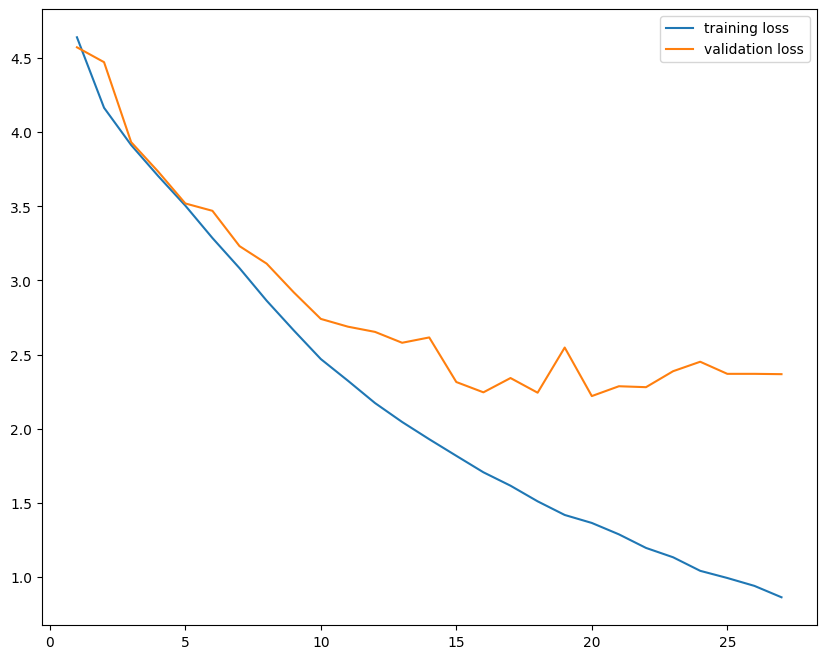

In [9]:

fig, ax = plt.subplots(figsize=(10,8))

ax.plot(range(1, len(train_loss_list)+1), train_loss_list, label="training loss")
ax.plot(range(1, len(valid_loss_list)+1), valid_loss_list, label="validation loss")
ax.legend()